# DESeq2 Analysis

The popular DESeq2 package in R is used to perform differential gene expression analysis.
DESeq2 is widely used for bulk RNA-seq count data, offering robust statistical methods to identify genes that are differentially expressed between experimental conditions.
The goal is to take raw count data, normalize it, and extract insights from significant changes in gene expression.

In [1]:
## Load data.
# Here we have the raw counts, which is the exact input we want for DESeq2.
# Raw counts are generated by tools such as featureCounts or HTSeq-count. 
counts_path <- file.path("../data/GSE164073_raw_counts_GRCh38.p13_NCBI.tsv.gz")
counts <- read.delim((counts_path))

# Observe the data
head(counts)

,GeneID,GSM4996084,GSM4996085,GSM4996086,GSM4996087,GSM4996088,GSM4996089,GSM4996090,GSM4996091,GSM4996092,GSM4996093,GSM4996094,GSM4996095,GSM4996096,GSM4996097,GSM4996098,GSM4996099,GSM4996100,GSM4996101
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,100287102,2,5,3,2,5,2,4,2,3,2,2,4,3,2,2,3,3,3
2,653635,244,236,337,266,317,226,303,196,219,202,168,201,235,221,270,262,234,314
3,102466751,25,17,34,22,24,19,23,15,21,15,19,22,15,17,16,18,17,23
4,107985730,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
5,100302278,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,645520,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [2]:
library(dplyr, quietly = TRUE)
library(tibble, quietly = TRUE)
# Set rownames to gene identifiers
count_mat <- counts %>%
  tibble::column_to_rownames("GeneID") %>%
  as.matrix()

print(head(count_mat))


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




          GSM4996084 GSM4996085 GSM4996086 GSM4996087 GSM4996088 GSM4996089
100287102          2          5          3          2          5          2
653635           244        236        337        266        317        226
102466751         25         17         34         22         24         19
107985730          1          1          1          0          0          0
100302278          0          0          0          0          0          0
645520             0          0          0          0          1          0
          GSM4996090 GSM4996091 GSM4996092 GSM4996093 GSM4996094 GSM4996095
100287102          4          2          3          2          2          4
653635           303        196        219        202        168        201
102466751         23         15         21         15         19         22
107985730          1          0          0          0          0          0
100302278          0          0          0          0          0          0
645520      

In [3]:
# Now we need to prepare a metadata table -
# so that DESeq2 knows which conditions exist and which comparisons are possible

# 
sample_info <- data.frame(
  tissue = rep(c("Cornea", "Limbus", "Sclera"), each = 6),
  condition = rep(rep(c("mock", "CoV2"), each = 3), times = 3),
  replicate = rep(1:3, times = 6),
  row.names = colnames(count_mat),
  stringsAsFactors = TRUE
)

# View the result and ensures it matches the information from GEO
sample_info

,tissue,condition,replicate
,<fct>,<fct>,<int>
GSM4996084,Cornea,mock,1
GSM4996085,Cornea,mock,2
GSM4996086,Cornea,mock,3
GSM4996087,Cornea,CoV2,1
GSM4996088,Cornea,CoV2,2
GSM4996089,Cornea,CoV2,3
GSM4996090,Limbus,mock,1
GSM4996091,Limbus,mock,2
GSM4996092,Limbus,mock,3


In [4]:
library(DESeq2, quietly = TRUE)
# Create DESeqDataSet object
dds <- DESeqDataSetFromMatrix(
  countData = count_mat,
  colData = sample_info,
  design = ~ tissue + condition  # Controls for tissue differences
)

## Filter genes
# Keep genes with at least 10 reads total
dds <- dds[rowSums(counts(dds)) >= 10, ]

# now we can run DESeq2
dds <- DESeq(dds)

print(dds)


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:dplyr':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following objects are masked from 'package:dplyr':

    first, rename


The following object is masked from 'package:utils':

    findMatches


The following objects are masked from 'package:base':

    expand.grid, I, unname



Attaching package: 'IRanges'


The following objects are maske

class: DESeqDataSet 
dim: 23713 18 
metadata(1): version
assays(4): counts mu H cooks
rownames(23713): 100287102 653635 ... 4576 4571
rowData names(30): baseMean baseVar ... deviance maxCooks
colnames(18): GSM4996084 GSM4996085 ... GSM4996100 GSM4996101
colData names(4): tissue condition replicate sizeFactor


using ntop=500 top features by variance



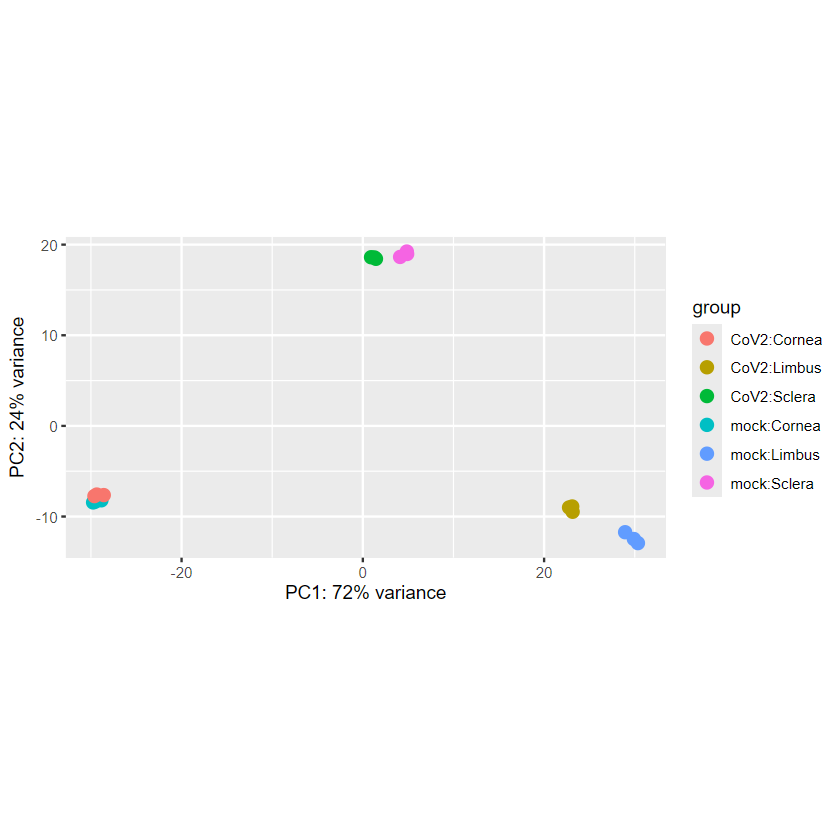

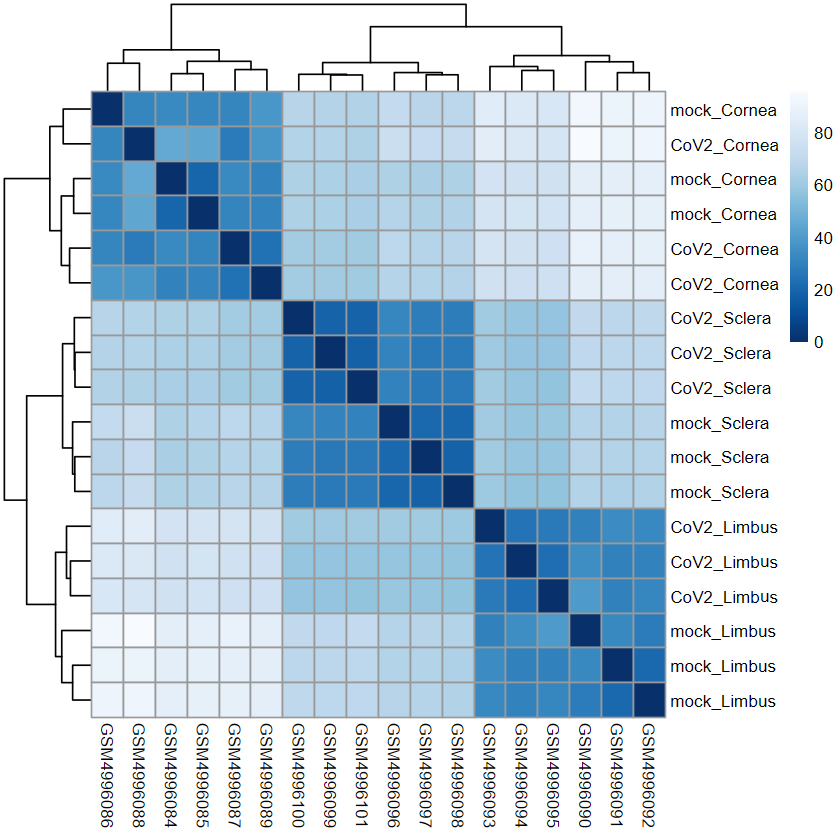

In [9]:
## Now that we have our data inside a DESeqDataSet object,
# let's observe the samples

library(pheatmap, quietly = TRUE)
library(RColorBrewer, quietly = TRUE)
# Variance stabilizing transformation for plotting
vsd <- vst(dds, blind = FALSE)

# PCA plot to assess sample clustering
DESeq2::plotPCA(vsd, intgroup = c("condition", "tissue"))

# Sample distance heatmap
sample_dists <- dist(t(assay(vsd)))
sample_dist_matrix <- as.matrix(sample_dists)
rownames(sample_dist_matrix) <- paste(vsd$condition, vsd$tissue, sep = "_")
pheatmap(sample_dist_matrix,
         clustering_distance_rows = sample_dists,
         clustering_distance_cols = sample_dists,
         color = colorRampPalette(rev(brewer.pal(9, "Blues")))(255))

We can see that the samples are clustering nicely by organ.
Also, all replicates are very similar to each other.
This is reassuring in terms of data quality

In [10]:
# Contrast: CoV2 vs mock, across tissues
res <- results(dds, contrast = c("condition", "CoV2", "mock"))
# Sort by adjusted p-value
res <- res[order(res$padj), ]

# Summary
summary(res)

print(head(res))


out of 23713 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1523, 6.4%
LFC < 0 (down)     : 2017, 8.5%
outliers [1]       : 0, 0%
low counts [2]     : 5517, 23%
(mean count < 5)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

log2 fold change (MLE): condition CoV2 vs mock 
Wald test p-value: condition CoV2 vs mock 
DataFrame with 6 rows and 6 columns
        baseMean log2FoldChange     lfcSE      stat       pvalue         padj
       <numeric>      <numeric> <numeric> <numeric>    <numeric>    <numeric>
6648   10970.746        2.92958 0.0825442   35.4911 6.74372e-276 1.22709e-271
7128     434.690        1.82686 0.0666871   27.3945 3.19202e-165 2.90410e-161
176     1570.387       -1.98213 0.0931557  -21.2776 1.83102e-100  1.11057e-96
718     3696.174        2.07764 0.0988591   21.0161  4.66934e-98  2.12408e-94
140876   339.291        1.79531 0.1082058   16.5916  8.00899e-62  2.91463e-58
70       571.818       -2

Warning message:
"Removed 5517 rows containing missing values or values outside the scale range
(`geom_point()`)."


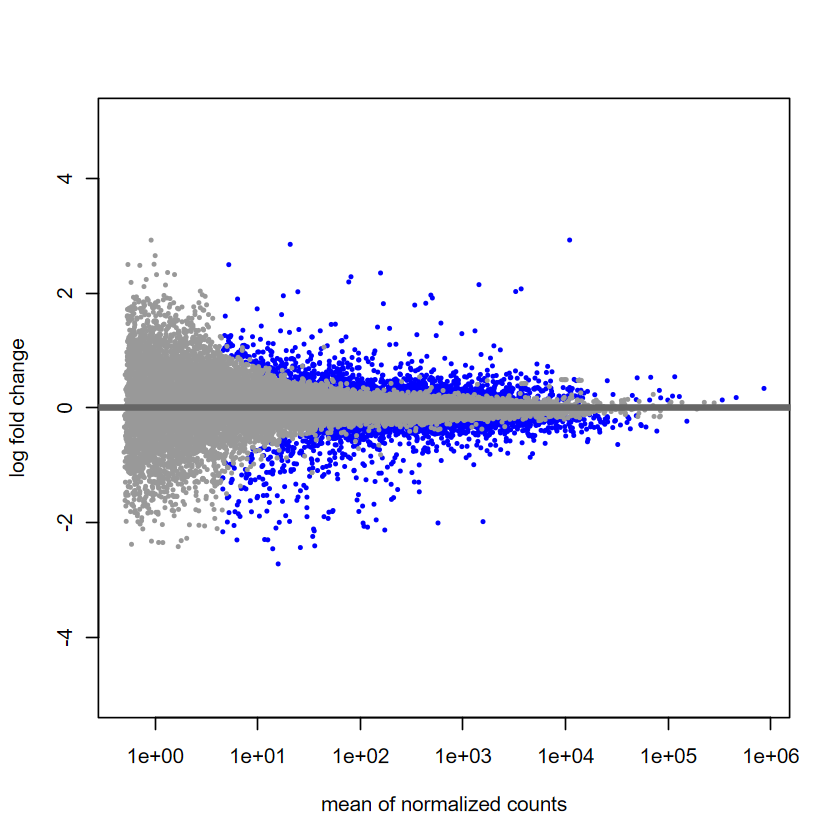

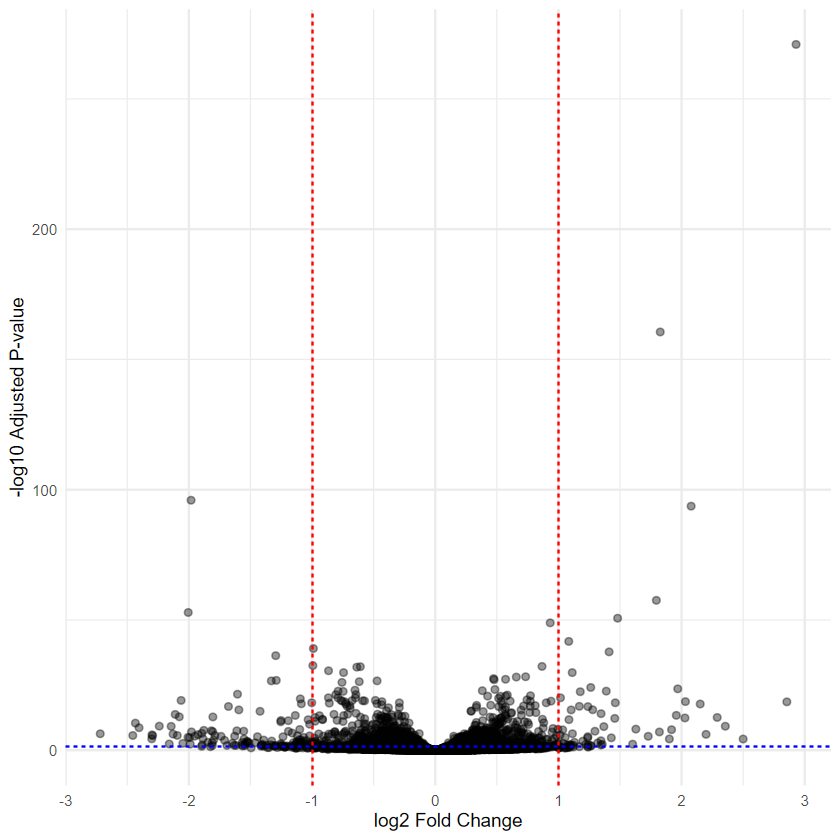

In [12]:
## Now let's visualize differential expression
library(ggplot2, quietly = TRUE)
# MA-plot
plotMA(res, ylim = c(-5, 5))

# Volcano plot
res$gene <- rownames(res)
ggplot(res, aes(x = log2FoldChange, y = -log10(padj))) +
  geom_point(alpha = 0.4) +
  theme_minimal() +
  xlab("log2 Fold Change") +
  ylab("-log10 Adjusted P-value") +
  geom_vline(xintercept = c(-1, 1), col = "red", linetype = "dashed") +
  geom_hline(yintercept = -log10(0.05), col = "blue", linetype = "dashed")